# Setup

 Import standard modules

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy
from time import perf_counter

Find project root, append to path, and define wdir for data

In [2]:
import os
os.chdir('/home/chris/projects/tidal_flat_0d')

In [3]:
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"

Import project modules from src folder

In [4]:
from src import features

In [149]:
tides = features.load_tide(wdir, "tides.feather")
tides = tides - (np.mean(tides) + 0.6)
# tides = tides[0:86400*28]

In [150]:
tide_elev = tides.values
init_land_elev = 1.0
index = np.arange(0, len(tides))
init_conc = 0.0
bound_conc = 1.0
grain_dia = 3.5e-5
grain_dens = 2.65e3
bulk_dens = 900
org_rate = 2e-4
comp_rate = 4e-3
sub_rate = 3e-3
slr = 0.0
method = "RK45"
runs = 1

In [151]:
from src import models
runs = 1
slr = 0

sim = models.Simulation(
    tide_elev=tide_elev,
    init_land_elev=init_land_elev,
    index=index,
    init_conc=init_conc,
    bound_conc=bound_conc,
    grain_dia=grain_dia,
    grain_dens=grain_dens,
    bulk_dens=bulk_dens,
    org_rate=org_rate,
    comp_rate=comp_rate,
    sub_rate=sub_rate,
    slr=slr,
    runs=runs,
)
sim.simulate()

Aggradation:           6.85e-02 m
Degradation:           -6.69e-03 m
Elevation change:      6.23e-02 m
Final elevation:       1.0623 m
Runtime:               00:04:54


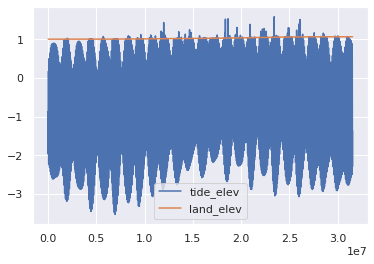

In [172]:
sim.results.plot(frac=0.01)

In [ ]:
def aggrade_rk(t, y, limb, dZdt_func, bound_conc, settle_rate, bulk_dens):

    # set values for concentration and elevation
    tide_elev = y[0]
    conc = y[1]
    land_elev = y[2]

    # use spline function for tide height to set current water_height
    depth = tide_elev - land_elev  # calculate current depth

    # use derivative of tide spline to get current gradient and set H
    dZdt = dZdt_func(t)

    if limb=='flood':
        dCdt = - (settle_rate * conc) / depth - 1 / depth * (conc - bound_conc) * dZdt
    elif limb=='ebb':
        dCdt = - (settle_rate * conc) / depth

    dEdt = settle_rate * conc / bulk_dens

    return [dZdt, dCdt, dEdt]

def aggrade_fd(index, tide_elev, init_land_elev, bound_conc, settle_rate, bulk_dens,):
    land_elev = np.array([init_land_elev])
    conc = np.array([0])
    depth = np.array([0.0001])
    for i in index:
        depth = np.append(depth, tide_elev[i] - land_elev[i])
        delta_conc = - settle_rate * conc[i] / depth[i] - 1 / depth[i] * (conc[i] - bound_conc) * (depth[i] - depth[i-1])
        conc = np.append(conc, conc[i-1] + delta_conc)
        delta_land_elev = settle_rate * conc[i] / bulk_dens
        land_elev = np.append(land_elev, land_elev[i-1] + delta_land_elev)
        
    return np.stack((depth, conc, land_elev))

inundation = sim.inundations[0]
limb = 'flood'
dZdt_func = inundation.tide_spline_deriv
bound_conc = inundation.bound_conc
settle_rate = inundation.settle_rate
bulk_dens = inundation.bulk_dens
start = inundation.start
slack = inundation.slack_time
end = inundation.end
tide_elev_start = inundation.tide_elev[0]
tide_elev = inundation.tide_elev
init_land_elev = inundation.init_land_elev